# Image wiener filtering

Wiener filters are usually applied in the frequency domain. Given a degraded image x(n,m), one takes the Discrete Fourier Transform (DFT) to obtain X(u,v). The original image spectrum is estimated by taking the product of X(u,v) with the Wiener filter G(u,v):  
$$Y(u,v) = X(u,v) * G(u,v) $$
The Wiener filter is defined in terms of these spectra :
H(u,v) : Fourier transform of the point-spread function.
SNR : signal-to-noise ratio in db.
The Wiener filter could be writing like :
$$G(u,v) = \dfrac{\bar{H}}{|H|^2+\dfrac{1}{SNR}}$$
where $SNR = \dfrac{P_{signal}}{P_{noise}}$,
P is power average.

In our case, $SNR = \dfrac{E[X^2]}{\sigma_N^2}$.

#### Decibels
Because many signals have a very wide dynamic range, signals are often expressed using the logarithmic decibel scale. Based upon the definition of decibel, signal and noise may be expressed in decibels (dB) as

$P_{signal,dB}=10\log_{{10}}(P_{signal})$

and

$P_{noise,dB}=10\log_{{10}}(P_{noise})$

In a similar manner, SNR may be expressed in decibels as 
SNR$_{db}=10\log_{{10}}(\dfrac{P_{signal}}{P_{noise}})$

## Image wiener filtering

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import scipy.ndimage as ndimage
from scipy.fftpack import ifft2, fft2

In [2]:
#Image reading in grey level / float64 conversion
img=np.float32(cv2.imread('barbara.jpg',cv2.IMREAD_GRAYSCALE))
(h,w) = img.shape
print("Dimensions of the image :",h,"rows x",w,"columns")
print("Type of the image :",img.dtype)

Dimensions of the image : 512 rows x 512 columns
Type of the image : float32


### Simulate a noisy version of the image with various SNR (0dB, 5 dB, 10 dB, 15 dB, 20 dB), using a Gaussian white noise

In [127]:
x_watts = img*img
#Set a target SNR
target_snr_db = 5
# Calculate signal power and convert to dB 
sig_puissance_watts = np.mean(x_watts)
sig_puissance_db = 10 * np.log10(sig_puissance_watts)
# Calculate noise according to [2] then convert to watts
noise_puissance_db = sig_puissance_db - target_snr_db
noise_puissance_watts = 10 ** (noise_puissance_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_puissance_watts), x_watts.shape)
img_noise = img + noise_volts

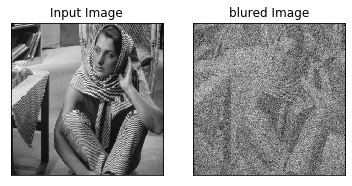

In [128]:
#Image display in grey level
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_noise, cmap = 'gray')
plt.title('blured Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Denoise the image using the Wiener filter

In [129]:
def gaussian_kernel(kernel_size=3):
    h = signal.gaussian(kernel_size,kernel_size/3).reshape(kernel_size,1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return(h)

In [130]:
def wiener_filter(img, kernel, s):
    img = np.copy(img)
    kernel = np.pad(kernel, [(0, img.shape[0] - kernel.shape[0]), (0, img.shape[1] - kernel.shape[1])], 'constant')
    # Fourier Transform
    img = fft2(img)
    kernel = fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + s)
    img = img * kernel
    img = np.abs(ifft2(img))
    return np.uint8(img)



In [131]:
n = 10 # kernel_size
kernel = gaussian_kernel(n) # gaussien filter
#kernel = np.ones((n,n))/(n*n) # average filter
s = 1/target_snr_db # the inverse of SNR
filtered_image = wiener_filter(img_noise, kernel, s)


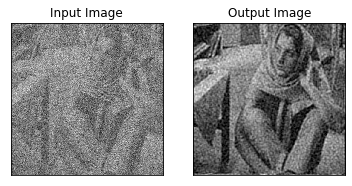

In [132]:
#Image display in grey level
plt.subplot(121),plt.imshow(img_noise, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(filtered_image, cmap = 'gray')
plt.title('Output Image'), plt.xticks([]), plt.yticks([])
plt.show()